In [ ]:
import urllib, json
def generate_toc(notebook_path, indent_char="&emsp;"):
    is_markdown = lambda it: "markdown" == it["cell_type"]
    is_title = lambda it: it.strip().startswith("#") and it.strip().lstrip("#").lstrip()
    with open(notebook_path, 'r') as in_f:
        nb_json = json.load(in_f)
    for cell in filter(is_markdown, nb_json["cells"]):
        for line in filter(is_title, cell["source"]):
            line = line.strip()
            indent = indent_char * (line.index(" ") - 1)
            title = line.lstrip("#").lstrip()
            url = urllib.parse.quote(title.replace(" ", "-"))
            out_line = f"{indent}[{title}](#{url})<br>\n"
            print(out_line, end="")
generate_toc('Martinez_Eva_3_notebook_prediction_TotalGHGEmissions_102022.ipynb')

[Import lib](#Import-lib)<br>
[Import data csv](#Import-data-csv)<br>
&emsp;[Energy consumption on a map](#Energy-consumption-on-a-map)<br>
[Prediction](#Prediction)<br>
&emsp;[Step 1 :Build pre-processing pipeline](#Step-1-%3ABuild-pre-processing-pipeline)<br>
&emsp;&emsp;[Split train/test](#Split-train/test)<br>
&emsp;[Step 2 : Evaluate some models](#Step-2-%3A-Evaluate-some-models)<br>
&emsp;&emsp;[SVR](#SVR)<br>
&emsp;&emsp;[Ridge](#Ridge)<br>
&emsp;&emsp;[Knn](#Knn)<br>
&emsp;&emsp;[Decision Tree](#Decision-Tree)<br>
&emsp;&emsp;[Gradient Boosting](#Gradient-Boosting)<br>
&emsp;&emsp;[Random Forest](#Random-Forest)<br>
&emsp;&emsp;[Summary Score](#Summary-Score)<br>
&emsp;&emsp;[Try log of target for best model : Gradient Boosting](#Try-log-of-target-for-best-model-%3A-Gradient-Boosting)<br>
&emsp;[Step 3 : Model Optimization of hyperparameters with Gridsearch (with log(target))](#Step-3-%3A-Model-Optimization-of-hyperparameters-with-Gridsearch-%28with-log%28target%29%29)<br>
&ems

# Import lib

In [ ]:
import pandas as pd
import numpy as np
import missingno as msno
import seaborn as sns
import matplotlib.pyplot as plt
from scipy.__config__ import show
import scipy.stats as stats
import math
import statsmodels.api as sm
from statsmodels.formula.api import ols
from sklearn import preprocessing
from sklearn import tree
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeRegressor
from sklearn.preprocessing import RobustScaler

from sklearn import svm
from sklearn.svm import SVR
from sklearn.neighbors import NearestNeighbors
from sklearn.neighbors import KNeighborsClassifier
from sklearn.neighbors import KNeighborsRegressor
from sklearn.tree import DecisionTreeClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import Ridge
from sklearn.model_selection import KFold
from sklearn.ensemble import RandomForestRegressor

from sklearn.ensemble import RandomForestClassifier 
from sklearn.model_selection import KFold
from sklearn.metrics import (confusion_matrix, precision_recall_curve, auc, roc_curve, recall_score, classification_report, f1_score, average_precision_score, precision_recall_fscore_support)
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import GridSearchCV
from sklearn.linear_model import SGDClassifier

from sklearn.linear_model import Lasso
from sklearn.pipeline import make_pipeline
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.svm import SVR
from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import GradientBoostingRegressor






# Import data csv

In [ ]:
df_cleaned = pd.read_csv('/content/df_cleaned.csv')
print(df_cleaned.head(3))

   Unnamed: 0  SiteEnergyUse(kBtu)  TotalGHGEmissions PrimaryPropertyType  \
0           0            7226362.5             249.98               Hotel   
1           1            8387933.0             295.86               Hotel   
2           2           72587024.0            2089.28               Hotel   

   Latitude  Longitude  YearBuilt  NumberofBuildings  NumberofFloors  \
0  47.61220 -122.33799       1927                1.0              12   
1  47.61317 -122.33393       1996                1.0              11   
2  47.61393 -122.33810       1969                1.0              41   

   PropertyGFABuilding(s)  PropertyGFAParking  ENERGYSTARScore  \
0                   88434                   0             60.0   
1                   88502               15064             61.0   
2                  759392              196718             43.0   

   proportion_SteamUse(kBtu)  proportion_Electricity(kBtu)  \
0                   0.277302                      0.546060   
1            

## Energy emission on a map

In [ ]:
df_cleaned = pd.read_csv('/content/df_cleaned.csv')

import folium

latmean = df_cleaned['Latitude'].mean()
lonmean = df_cleaned['Longitude'].mean()
map = folium.Map(location=[latmean,lonmean], 
        zoom_start=6) 

def color(value): 
    if value in range(0,19): 
        col = 'green'
    elif value in range(20,48): 
        col = 'orange'
    else:
        col = 'red'
    return col 
      
map = folium.Map(location=[latmean,lonmean], 
        zoom_start=6) 

df_cleaned['TotalGHGEmissions'] = df_cleaned['TotalGHGEmissions'].astype('int')

print('min',df_cleaned['TotalGHGEmissions'].min())
print('max',df_cleaned['TotalGHGEmissions'].max())
print('mean',df_cleaned['TotalGHGEmissions'].mean())
print('median',df_cleaned['TotalGHGEmissions'].median())

print("Q1 quantile of arr : ", np.quantile(df_cleaned['TotalGHGEmissions'], .25))
print("Q2 quantile of arr : ", np.quantile(df_cleaned['TotalGHGEmissions'], .50))
print("Q3 quantile of arr : ", np.quantile(df_cleaned['TotalGHGEmissions'], .75))


# # 
for lat,lan,value in zip(df_cleaned['Latitude'],df_cleaned['Longitude'],df_cleaned['TotalGHGEmissions']): 
    folium.Marker(location=[lat,lan],icon= folium.Icon(color=color(value),icon_color='black',icon = 'home')).add_to(map) 
map

min 0
max 12307
mean 175.49117341640707
median 48.0
Q1 quantile of arr :  19.0
Q2 quantile of arr :  48.0
Q3 quantile of arr :  136.5


# Prediction

## Step 1 :Build pre-processing pipeline
*   Encode qualitative features (one hot encoding)
*   Scale features
*   Define features and target





In [ ]:
# Scaler
scaler = StandardScaler(with_mean=False)

# Encoder
categorical_features = ['PrimaryPropertyType', 'YearBuilt','NumberofBuildings']
categorical_transformer = OneHotEncoder(handle_unknown="ignore")

features_predict_emission = ['PrimaryPropertyType',
       'Latitude', 'Longitude', 'YearBuilt', 'NumberofBuildings',
       'NumberofFloors', 'PropertyGFABuilding(s)','PropertyGFAParking']

# Define features and Target
X = df_cleaned.loc[:, features_predict_emission]
y = df_cleaned.loc[:, ['TotalGHGEmissions']]

# Build the preprocessor
preprocessor = ColumnTransformer(
    transformers=[
        ("cat", categorical_transformer, categorical_features),
    ], remainder='passthrough'
)


### Split train/test

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=0, train_size = 0.75)

## Step 2 : Evaluate some models 



In [ ]:
# Create two list that will gathers the test score associated to the model
models =[]
score_test= []

### SVR

In [ ]:
models.append('SVR')

regression = SVR(kernel='rbf')
cv= KFold(n_splits=3, random_state=1, shuffle=True)
model_svr = make_pipeline(preprocessor, scaler, regression)

print('Score with cross val  :', cross_val_score(model_svr, X_train, y_train.values.ravel(), cv=cv))

model_svr.fit(X_train, y_train.values.ravel())
print('Score on test', model_svr.score(X_test,y_test.values.ravel()))

score_test.append(model_svr.score(X_test,y_test.values.ravel()))








Score with cross val  : [-0.04920579 -0.0220603  -0.0410431 ]
Score on test -0.04387080286828282


### Ridge

In [ ]:
models.append('Ridge')

regression = Ridge()
cv= KFold(n_splits=3, random_state=1, shuffle=True)
model_ridge = make_pipeline(preprocessor, scaler, regression)
print('Score with cross val :', cross_val_score(model_ridge, X_train, y_train.values.ravel(), cv=cv))
# print('neg_mean_absolute_error',cross_val_score(model_ridge, X_train, y_train, cv=cv,scoring='neg_mean_absolute_error'))
# print('neg_root_mean_squared_error',cross_val_score(model_ridge, X_train, y_train, cv=cv,scoring='neg_root_mean_squared_error'))

model_ridge.fit(X_train, y_train.values.ravel())
print('Score on test', model_ridge.score(X_test,y_test.values.ravel()))

score_test.append(model_ridge.score(X_test,y_test.values.ravel()))



Score with cross val : [-0.38189301  0.55811744  0.52373945]
Score on test 0.6580531516643754


### Knn

In [ ]:
models.append('Knn k=5')

cv= KFold(n_splits=3, random_state=1, shuffle=True)

for i in range (2,16):
  regression = KNeighborsRegressor(n_neighbors=i)
  model_knn = make_pipeline(preprocessor, scaler, regression)
  print('k =',i, cross_val_score(model_knn, X_train, y_train.values.ravel(), cv=cv))

regression = KNeighborsRegressor(n_neighbors=5)
model_knn = make_pipeline(preprocessor, scaler, regression)
model_knn.fit(X_train, y_train.values.ravel())
score_test.append(model_knn.score(X_test,y_test.values.ravel()))



# Bad performance no matter which k is chosen no did not score on test for a particular k

k = 2 [-0.0114765  -0.02363236  0.0285818 ]
k = 3 [0.00072366 0.06261494 0.02155765]
k = 4 [-0.00106352  0.05617193  0.01971927]
k = 5 [0.0537012  0.05815312 0.00482498]
k = 6 [0.02696965 0.05416726 0.00737222]
k = 7 [0.02089255 0.09407643 0.01008597]
k = 8 [0.02032632 0.08201683 0.01035487]
k = 9 [0.02816993 0.07953846 0.00831322]
k = 10 [0.02833046 0.08775673 0.01486481]
k = 11 [0.03138136 0.08092979 0.01685174]
k = 12 [0.03272581 0.07829645 0.01689126]
k = 13 [0.03228725 0.07517957 0.01419724]
k = 14 [0.03138673 0.06935999 0.01309284]
k = 15 [0.03000277 0.0636316  0.01285452]


### Decision Tree

In [ ]:
models.append('Decision tree')

regression = DecisionTreeRegressor()
cv= KFold(n_splits=3, random_state=1, shuffle=True)
model_decisiontree = make_pipeline(preprocessor, scaler, regression)
print('Score with cross val :', cross_val_score(model_decisiontree, X_train, y_train.values.ravel(), cv=cv))

model_decisiontree.fit(X_train, y_train.values.ravel())
print('Score on test', model_decisiontree.score(X_test,y_test.values.ravel()))

score_test.append(model_decisiontree.score(X_test,y_test.values.ravel()))

Score with cross val : [-6.27909998  0.0329832   0.02438507]
Score on test 0.683423271323214


### Gradient Boosting

In [ ]:
models.append('Gradient Boosting')
regression = GradientBoostingRegressor()
cv= KFold(n_splits=3, random_state=1, shuffle=True)
model_gradientboosting = make_pipeline(preprocessor, scaler, regression)
print('Score with cross val :', cross_val_score(model_gradientboosting, X_train, y_train.values.ravel(), cv=cv))

model_gradientboosting.fit(X_train, y_train.values.ravel())
print('Score on test', model_gradientboosting.score(X_test,y_test.values.ravel()))

score_test.append(model_gradientboosting.score(X_test,y_test.values.ravel()))

Score with cross val : [0.7011501  0.48033329 0.14298108]
Score on test 0.7099186577257317


### Random Forest

In [ ]:
models.append('Random Forest')

cv= KFold(n_splits=3, random_state=1, shuffle=True)

regression = RandomForestRegressor()
model_randomforest = make_pipeline(preprocessor, scaler, regression)

print('Score with cross val : ' , cross_val_score(model_randomforest, X_train, y_train.values.ravel(), cv=cv))

model_randomforest.fit(X_train, y_train.values.ravel())

print('Score on test', model_randomforest.score(X_test,y_test))

score_test.append(model_randomforest.score(X_test,y_test.values.ravel()))

Score with cross val :  [0.43685619 0.45991991 0.21580431]
Score on test 0.7111525002409311


### Summary Score 

(-0.1, 1.0)

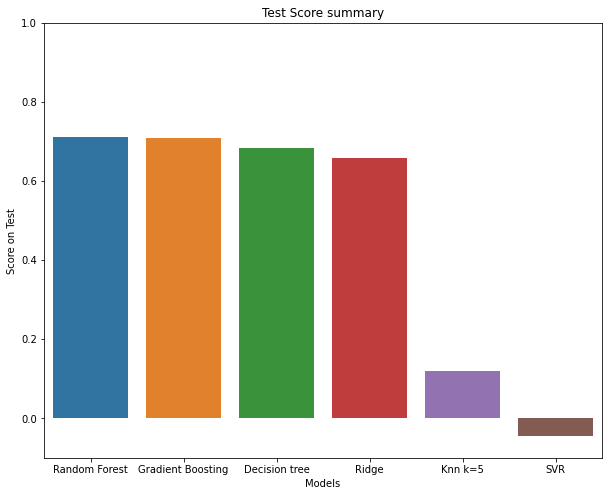

In [ ]:
models_np = np.array(models)
score_test_np = np.array(score_test)

summary_models_score_test={'Models':models_np,'Score on Test':score_test_np}
df_summary_models_score_test = pd.DataFrame(summary_models_score_test)
df_summary_models_score_test.sort_values(by=['Score on Test'],ascending=False,inplace=True)

#Define size of bar plot
plt.figure(figsize=(10,8))
#Plot Searborn bar chart
sns.barplot(x=df_summary_models_score_test['Models'], y=df_summary_models_score_test['Score on Test'])

# Add chart labels
plt.title('Test Score summary')
plt.ylim(-0.1, 1)


### Try log of target for best model : Gradient Boosting

Score with cross val :  [0.56281124 0.57933725 0.64717216]
Score on test with log(target) 0.597852558247084


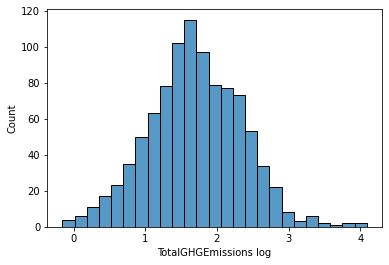

In [ ]:
# Get log of 'SiteEnergyUse(kBtu)'
df_cleaned = pd.read_csv('/content/df_cleaned.csv')
df_cleaned['TotalGHGEmissions log'] = np.log10(df_cleaned['TotalGHGEmissions'])
df_cleaned.drop('TotalGHGEmissions', inplace=True, axis=1)
sns.histplot(df_cleaned['TotalGHGEmissions log'])

# Redefine target
y_log = df_cleaned.loc[:, ['TotalGHGEmissions log']]

X_train_log, X_test_log, y_train_log, y_test_log = train_test_split(X, y_log, random_state=0, train_size = 0.75)

cv= KFold(n_splits=3, random_state=1, shuffle=True)

regression = GradientBoostingRegressor()
model_gb_log = make_pipeline(preprocessor, scaler, regression)

print('Score with cross val : ' , cross_val_score(model_gb_log, X_train_log, y_train_log.values.ravel(), cv=cv))

model_gb_log.fit(X_train_log, y_train_log.values.ravel())

print('Score on test with log(target)', model_gb_log.score(X_test_log,y_test_log))


## Step 3 : Model Optimization of hyperparameters with Gridsearch (with log(target))

In [ ]:
# Create three list that will gathers the test and train score associated to the model
models_list = []
train_score = []
test_score = []


### Gridsearch Ridge

In [ ]:
models_list.append('Ridge')
param_grid = {
    'ridge__alpha': [150,200,300,400]
}

# Instantiate the grid search model
grid_search = GridSearchCV(estimator = model_ridge, param_grid = param_grid, 
                          cv = 3, n_jobs = -1, verbose = 2)

# Fit the grid search to the data
grid_search.fit(X_train, y_train.values.ravel())
print('Best param', grid_search.best_params_)

# Input the best parameters found
regression_ridge = Ridge(alpha=grid_search.best_params_['ridge__alpha'])
model_ridge_final = make_pipeline(preprocessor, scaler, regression_ridge)

model_ridge_final.fit(X_train, y_train.values.ravel())
print('Score on train', model_ridge_final.score(X_train,y_train))
print('Score on test', model_ridge_final.score(X_test,y_test))
train_score.append(model_ridge_final.score(X_train,y_train))
test_score.append(model_ridge_final.score(X_test,y_test))




Fitting 3 folds for each of 4 candidates, totalling 12 fits
Best param {'ridge__alpha': 400}
Score on train 0.8796701125538268
Score on test 0.6308625579495464


### Gridsearch Random forest

In [ ]:
models_list.append('Random forest')

param_grid = {
    'randomforestregressor__min_samples_leaf': [1,2,5,10],
    'randomforestregressor__n_estimators': [50,70,100, 200,300]
}

# Instantiate the grid search model
grid_search = GridSearchCV(estimator = model_randomforest, param_grid = param_grid, 
                          cv = 3, n_jobs = -1, verbose = 2)

# Fit the grid search to the data
grid_search.fit(X_train, y_train.values.ravel())
print('Best param', grid_search.best_params_)





Fitting 3 folds for each of 20 candidates, totalling 60 fits
Best param {'randomforestregressor__min_samples_leaf': 2, 'randomforestregressor__n_estimators': 300}


In [ ]:
# Input the best parameters found
regression = RandomForestRegressor(min_samples_leaf=grid_search.best_params_['randomforestregressor__min_samples_leaf'], n_estimators=grid_search.best_params_['randomforestregressor__n_estimators'])
model_randomforest_final = make_pipeline(preprocessor, scaler, regression)

model_randomforest_final.fit(X_train, y_train.values.ravel())

print('Score on train', model_randomforest_final.score(X_train,y_train))
print('Score on test', model_randomforest_final.score(X_test,y_test))
train_score.append(model_randomforest_final.score(X_train,y_train))
test_score.append(model_randomforest_final.score(X_test,y_test))


Score on train 0.8185336044671554
Score on test 0.7346907065135684


### Gridsearch Decision tree

In [ ]:
models_list.append('Decision tree')
regression = DecisionTreeRegressor()
model_decisiontree = make_pipeline(preprocessor, scaler, regression)
model_decisiontree.fit(X_train, y_train.values.ravel())
print('Score on test', model_decisiontree.score(X_test,y_test.values.ravel()))

param_grid = {"decisiontreeregressor__splitter":["best","random"],
            "decisiontreeregressor__max_depth" : [1,5,10,50,100],
           "decisiontreeregressor__min_samples_leaf":[2,5,10,15],
           "decisiontreeregressor__max_leaf_nodes":[400,600,700]
}


# Instantiate the grid search model
grid_search = GridSearchCV(estimator = model_decisiontree, param_grid = param_grid, 
                          cv = 4, n_jobs = -1, verbose = 2)

# Fit the grid search to the data
grid_search.fit(X_train, y_train.values.ravel())
print('Best param', grid_search.best_params_)



Score on test 0.6007336978602371
Fitting 4 folds for each of 120 candidates, totalling 480 fits
Best param {'decisiontreeregressor__max_depth': 50, 'decisiontreeregressor__max_leaf_nodes': 600, 'decisiontreeregressor__min_samples_leaf': 2, 'decisiontreeregressor__splitter': 'random'}


In [ ]:
# Input the best parameters found
regression_decisiontree = DecisionTreeRegressor(max_depth= grid_search.best_params_['decisiontreeregressor__max_depth'], max_leaf_nodes= grid_search.best_params_['decisiontreeregressor__max_leaf_nodes'], min_samples_leaf=grid_search.best_params_['decisiontreeregressor__min_samples_leaf'], splitter=grid_search.best_params_['decisiontreeregressor__splitter'])
model_decisiontree = make_pipeline(preprocessor, scaler, regression_decisiontree)

model_decisiontree.fit(X_train, y_train.values.ravel())
print('Score on train', model_decisiontree.score(X_train,y_train))
print('Score on test', model_decisiontree.score(X_test,y_test))
train_score.append(model_decisiontree.score(X_train,y_train))
test_score.append(model_decisiontree.score(X_test,y_test))


Score on train 0.7635102736444741
Score on test 0.5977296661577445


###Gridsearch Gradientboosting

In [ ]:
models_list.append('Gradient Boosting')

regression = GradientBoostingRegressor()
model_gb = make_pipeline(preprocessor, scaler, regression)
model_gb.fit(X_train, y_train.values.ravel())
print('Score on test', model_gb.score(X_test,y_test.values.ravel()))

param_grid = {'gradientboostingregressor__learning_rate': [0.1,0.3,0.5],
                  'gradientboostingregressor__n_estimators' : [80,100,150],
                  'gradientboostingregressor__max_depth'    : [2,10,50]
                 }


# Instantiate the grid search model
grid_search = GridSearchCV(estimator = model_gb, param_grid = param_grid, 
                          cv = 4, n_jobs = -1, verbose = 2)

# Fit the grid search to the data
grid_search.fit(X_train, y_train.values.ravel())
print('Best param', grid_search.best_params_)

Score on test 0.7882645144939318
Fitting 4 folds for each of 27 candidates, totalling 108 fits
Best param {'gradientboostingregressor__learning_rate': 0.1, 'gradientboostingregressor__max_depth': 2, 'gradientboostingregressor__n_estimators': 150}


In [ ]:
regression_gb = GradientBoostingRegressor(learning_rate = grid_search.best_params_['gradientboostingregressor__learning_rate'], max_depth=grid_search.best_params_['gradientboostingregressor__max_depth'], n_estimators= grid_search.best_params_['gradientboostingregressor__n_estimators'])
model_gb = make_pipeline(preprocessor, scaler, regression_gb)

model_gb.fit(X_train, y_train.values.ravel())
print('Score on train', model_gb.score(X_train,y_train))
print('Score on test', model_gb.score(X_test,y_test))

train_score.append(model_gb.score(X_train,y_train))
test_score.append(model_gb.score(X_test,y_test))

Score on train 0.9792765330727237
Score on test 0.8468581085616557


### Summary plot gridsearch Score train/test

(0.0, 1.0)

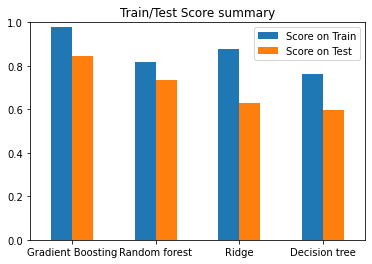

In [ ]:
models_np = np.array(models_list)
score_train_np = np.array(train_score)
score_test_np = np.array(test_score)

summary_models_score_test=({'Models':models_np,'Score on Train':score_train_np,'Score on Test':score_test_np})
df_summary_models_score_test = pd.DataFrame(summary_models_score_test,index=models_np)
df_summary_models_score_test.sort_values(by=['Score on Test'],ascending=False,inplace=True)


#Plot Searborn bar chart
ax = df_summary_models_score_test.plot.bar(rot=0)

# Add chart labels
plt.title('Train/Test Score summary')
plt.ylim(0, 1)

## Step 4 : Does adding energy Star Score improve the model ? 

In [ ]:
df = pd.read_csv('/content/df_cleaned.csv')
features_predict_energy = ['PrimaryPropertyType',
       'Latitude', 'Longitude', 'YearBuilt', 'NumberofBuildings',
       'NumberofFloors', 'PropertyGFABuilding(s)','PropertyGFAParking','ENERGYSTARScore']

X = df.loc[:, features_predict_energy]
y_log = df.loc[:, ['TotalGHGEmissions']]


X_train, X_test, y_train, y_test = train_test_split(X, y_log, random_state=0, train_size = 0.75)

regression_gb = GradientBoostingRegressor(learning_rate = grid_search.best_params_['gradientboostingregressor__learning_rate'], max_depth=grid_search.best_params_['gradientboostingregressor__max_depth'], n_estimators= grid_search.best_params_['gradientboostingregressor__n_estimators'])
model_gb = make_pipeline(preprocessor, scaler, regression_gb)

model_gb.fit(X_train, y_train.values.ravel())
print('Score on train', model_gb.score(X_train,y_train))
print('Score on test', model_gb.score(X_test,y_test))



Score on train 0.9821680397052941
Score on test 0.8421677570639656


### Feature importance

/usr/local/lib/python3.8/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)


              feature_names  feature_importance
1          cat__x0_Hospital            0.461675
133  PropertyGFABuilding(s)            0.315172
128             cat__x2_7.0            0.070096
130                Latitude            0.061792
129             cat__x2_9.0            0.035562
135         ENERGYSTARScore            0.031617
2             cat__x0_Hotel            0.005521
72             cat__x1_1964            0.003095
5    cat__x0_Medical Office            0.003017
37             cat__x1_1922            0.002431


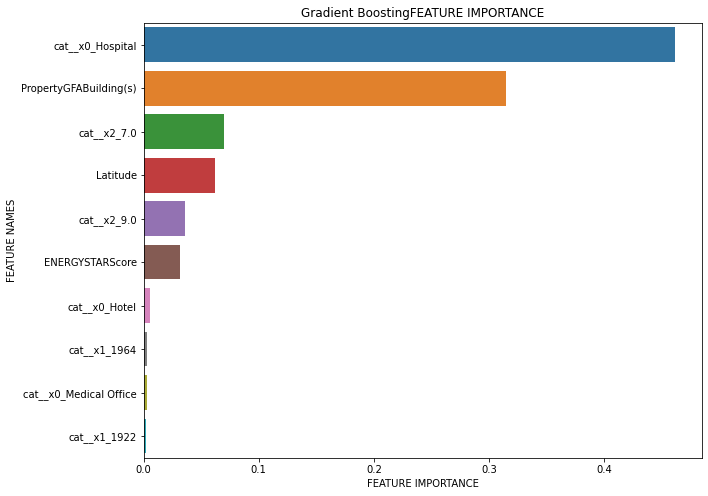

In [ ]:
feature_names = model_gb[0].get_feature_names()
feature_importance = model_gb[2].feature_importances_

def plot_feature_importance(importance,names,model_type):
  #Create arrays from feature importance and feature names
  feature_importance = np.array(importance)
  feature_names = np.array(names)

  #Create a DataFrame using a Dictionary
  data={'feature_names':feature_names,'feature_importance':feature_importance}
  fi_df = pd.DataFrame(data)
  
  #Sort the DataFrame in order decreasing feature importance
  fi_df.sort_values(by=['feature_importance'],ascending=False,inplace=True)
  fi_df = fi_df.head(10)
  print(fi_df)

  #Define size of bar plot
  plt.figure(figsize=(10,8))
  #Plot Searborn bar chart
  sns.barplot(x=fi_df['feature_importance'], y=fi_df['feature_names'])
  #Add chart labels
  plt.title(model_type + 'FEATURE IMPORTANCE')
  plt.xlabel('FEATURE IMPORTANCE')
  plt.ylabel('FEATURE NAMES')

plot_feature_importance(feature_importance,feature_names,'Gradient Boosting')

